# Virtual Staining with Conditional GAN

In this example, we will build a conditional GAN to transform brightfield microscopy images of human motor neurons to fluorescent images. The application is known as virtual staining as once trained the model can be used to generate fluorescent images without actually performing chemical staining of the cells.

## Human motor neurons dataset

The dataset used in this example is part of the article [*In silico* Labelling: Predicting Fluorescent Labels in Unlabeled Images](https://www.cell.com/cell/fulltext/S0092-8674(18)30364-7). We will be using the human motor neurons dataset that is designated as **Condition A** in the article. 

The dataset contains 22 brightfield images and the corresponding spatially registered fluorescent images with 2 fluorescent channels, Hoechst (blue stain representing nuceli) and anti-Tuj1 (red stain representing neurons). Each brightfield image contains z-stack of 13 images representing different focal planes. The dataset can be downloaded using the following instructions.



### Download the dataset

We will download the dataset using the `gsutil` command line tool. The dataset is stored in a public Google Cloud Storage bucket by the authors of the article. The dataset is about 10 GB in size and will take a few minutes to download depending on your internet connection.

1. Install `gsutil` command line tool using the following command.
    ```bash
    pip install gsutil
    ```

2. Download the train and test datasets using the following commands. Notice that the path string contains two paths separated by space. The first path is the path to the dataset in the Google Cloud Storage bucket and the second path is the path to the directory where you want to download the dataset. The dataset will be downloaded to the `train` and `test` subdirectories of the path you specify.
    ```bash
    # Download the train dataset
    gsutil -m cp -r gs://in-silico-labeling/paper_data/train/Rubin/scott_1_0 /VirtualStainingDataset/train
    # Download the test dataset
    gsutil -m cp -r gs://in-silico-labeling/paper_data/test/Rubin/scott_1_0 /VirtualStainingDataset/test
    ```

Once downloaded, we will use the custom dataset class `VirtualStainingDataset` that is available in the python file `dataset.py`. The dataset class works like a regular PyTorch dataset class which can load train and test datasets, and apply transformations to the images.

Before we import the dataset class, we will define the augmentations, transformations, and the normalization that we are going to apply to the images using the `torchvision` library.

Firstly, we will crop the images to the size of `256x256` pixels. Then we will apply random horizontal and vertical flips to the images. Finally, we will normalize the images using the mean and standard deviation of the images in the training dataset.

In [1]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomCrop((256,256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
])

normalize = [
    transforms.Normalize(mean=[0.5] * 13, std=[0.5] * 13), # Input
    transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3) # Target
]

We will now import the `VirtualStainingDataset` class from `dataset.py` and create the train and test datasets. The `VirtualStainingDataset` class takes the following arguments, `root`, `train`, `transform`, `normalize` and `preload`.

Here, `root` is the path to the dataset folder. The `train` argument is a boolean value that indicates whether to load the train or test datasets.

The `transform` and `normalize` arguments accept the transforms and the normalizations that we created in the above cell.

By setting the `preload` argument to `True`, we can preload the entire dataset into memory to speed up the training. If you have enough memory, it is recommended to set this argument to `True`.

In [2]:
import sys
sys.path.insert(0, '/workspace/virtual_staining') # adjust the path accodingly

from dataset import VirtualStainingDataset

root = "/workspace/virtual_staining/NewDataset" # adjust the path accodingly

train_dataset = VirtualStainingDataset(root, train=True, transform=transform, normalize=normalize, preload=True)
test_dataset = VirtualStainingDataset(root, train=False, transform=transform, normalize=normalize, preload=True)

Preloading images: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.13s/it]


We can now visualize some images from the train dataset using the `matplotlib` library. We will visualize the brightfield image averaged over all the focal planes and the corresponding fluorescent images. We will use `numpy` to randomly sample the images from the dataset.

Since we have normalized the images to be in the range of `[-1, 1]`, we will create a small function `denormalize` to convert the images back to the range of `[0, 1]` for visualization.

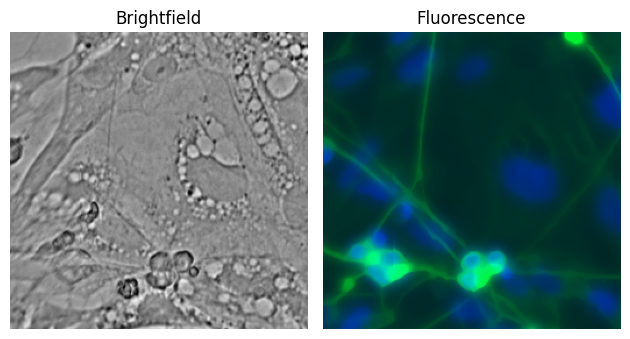

In [17]:
import numpy as np
import matplotlib.pyplot as plt

brightfield_img, fluorescence_img = train_dataset[np.random.randint(0, len(train_dataset))]

def denormalize(image):
    return image * 0.5 + 0.5

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(brightfield_img.mean(axis=0), cmap='gray')
plt.title('Brightfield')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(denormalize(fluorescence_img.permute(1, 2, 0)))
plt.title('Fluorescence')
plt.axis('off')
plt.tight_layout()
plt.show()

Let us now visualize the fluorescent image channel wise, i.e., Hoechst (representing neurons) and anti-Tuj1 (representing motor neurons) channels for blue and green channels respectively. Note that the red channel is empty as the fluorescent images do not contain any red channel.

Let us create the function `process_label` to achieve this.

In [18]:
import numpy as np
from skimage.exposure import rescale_intensity

def process_label(label, channel='G'):
    # Create zero arrays for the other two channels
    zero_channel = np.zeros_like(label)

    # Map the channels to their corresponding arrays
    channels = {
        'R': [label if channel == 'R' else zero_channel, 
              zero_channel, 
              zero_channel],
        'G': [zero_channel, 
              label if channel == 'G' else zero_channel, 
              zero_channel],
        'B': [zero_channel, 
              zero_channel, 
              label if channel == 'B' else zero_channel]
    }

    # Create the stack using the specified channel order
    stack = [rescale_intensity(channels[channel][i], out_range="float") for i in range(3)]

    return np.stack(stack, axis=-1)

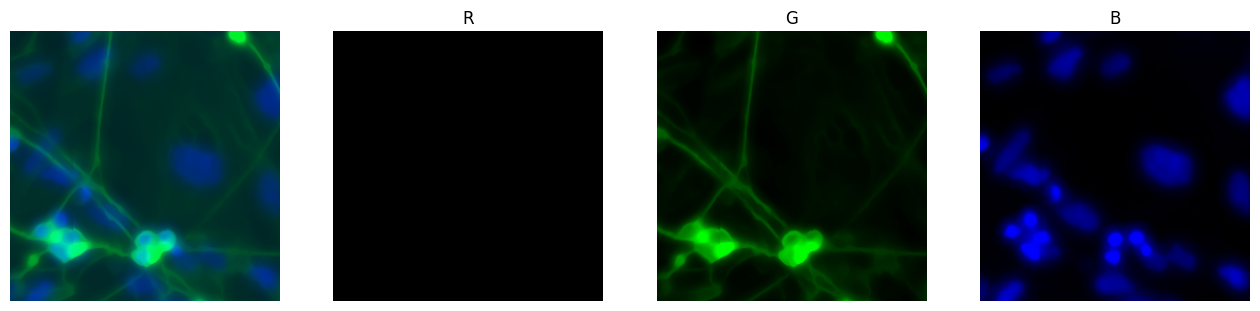

In [19]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 4, 1)
plt.imshow(denormalize(fluorescence_img.permute(1, 2, 0)))
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(process_label(denormalize(fluorescence_img.permute(1, 2, 0).numpy()[:,:,0]), channel="R"))
plt.title("R")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(process_label(denormalize(fluorescence_img.permute(1, 2, 0).numpy()[:,:,1]), channel="G"))
plt.title("G")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(process_label(denormalize(fluorescence_img.permute(1, 2, 0).numpy()[:,:,2]), channel="B"))
plt.title("B")
plt.axis('off')

plt.show()

We now define the `device` that we are going to use for training. We will use the GPU if available, else we will use the CPU.

In [20]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Generator and Discriminator

In this section, we will define the generator and discriminator networks that we will be using to train a conditional GAN. We will be using the `deeplay` library to define the networks.

### Generator

We will use the class `UNet2d` from `deeplay` to define the generator network. We will set the `in_channels` to be 13 as the brightfield images contain 13 focal planes. We will set the `out_channels` to be 3. The generator will take the brightfield image as input and output the fluorescent image. We will define the number of filters in the hidden layers using the `channels` parameter.

We will also be modifying the activations of hidden layers to `LeakyReLU` and the activation of the output layer to `Tanh`. We will also be using `InstanceNorm2d` instead of `BatchNorm2d` as it is known to perform better in image-to-image translation tasks.

In [21]:
import deeplay as dl
import torch.nn as nn

generator = dl.UNet2d(
    in_channels=13,
    # channels=[32, 64, 128, 256], # This works well already
    channels=[32, 64, 128, 256, 512], # Just to give generator more capacity
    out_channels=3,
)

# Modify the activations for the encoder and decoder networks in UNet
generator.encoder.activation.configure(nn.LeakyReLU, negative_slope=0.2)
generator.decoder.activation[:-1].configure(nn.LeakyReLU, negative_slope=0.2)

# Change the output activation
generator.decoder.activation[-1].configure(nn.Tanh)

# Change normalization to InstanceNorm2d
generator.decoder.normalization[:-1].configure(nn.InstanceNorm2d)

# Change the order of the normalization and activation in the encoder and decoder
generator.encoder.blocks.configure(order=["layer", "normalization", "activation"])
generator.decoder.blocks.configure(order=["layer", "normalization", "activation"])

# Build the network
generator.build()

# Send to device
generator.to(device)

UNet2d(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): PoolLayerActivationNormalization(
        (layer): Conv2d(13, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (normalization): Identity()
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (1): PoolLayerActivationNormalization(
        (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (normalization): Identity()
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (2): PoolLayerActivationNormalization(
        (layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (normalization): Identity()
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (3): PoolLayerActivationNormalization(
        (layer): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (normalization): Identity()
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (4): PoolLayerActivationN

### Discriminator

Now we will define the discriminator network for the conditional GAN. The network will the take the fluorescent image (either generated by the generator or the label), along the brightfield image (which acts as a condition) as inputs and outputs a single value representing the probability of the image being real or fake.

We will use the class `ConvolutionalNeuralNetwork` from `deeplay` to define the discriminator network. Since we have 13 channels in the brightfield image and 3 channels in the fluorescent image, we will set the `in_channels` to be 16. We will set the `out_channels` to be 1 as the discriminator will output a single value. We will define the number of filters in the hidden layers using the `channels` parameter.

We will also be modifying the activations of hidden layers to `LeakyReLU` and the activation of the output layer to `Sigmoid`. We will also be using `InstanceNorm2d` instead of `BatchNorm2d` as it is known to perform better in image-to-image translation tasks.

In [22]:
discriminator = dl.ConvolutionalNeuralNetwork(
    in_channels=16,
    # hidden_channels=[16, 32, 64, 128], # This works well too
    hidden_channels=[8, 16, 32, 64], # Making the discriminator more weak
    out_channels=1,
)

# Change convolutional layer parameters
discriminator.blocks.layer.configure(kernel_size=4, stride=2, padding=1)

# Change activation
discriminator.blocks.activation[:-1].configure(nn.LeakyReLU, negative_slope=0.2)

# Change the output activation
discriminator.blocks.activation[-1].configure(nn.Sigmoid)

# Change normalization
discriminator.blocks.normalization[1:-1].configure(nn.InstanceNorm2d)

# Change the order of layer, activation, normalization
discriminator.blocks.configure(order=["layer", "normalization", "activation"])

# Build the network
discriminator.build()

# Send to the device
discriminator.to(device)

ConvolutionalNeuralNetwork(
  (blocks): LayerList(
    (0): PoolLayerActivationNormalization(
      (layer): Conv2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (normalization): Identity()
      (activation): LeakyReLU(negative_slope=0.2)
    )
    (1): PoolLayerActivationNormalization(
      (layer): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (normalization): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (activation): LeakyReLU(negative_slope=0.2)
    )
    (2): PoolLayerActivationNormalization(
      (layer): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (normalization): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (activation): LeakyReLU(negative_slope=0.2)
    )
    (3): PoolLayerActivationNormalization(
      (layer): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (normalization): InstanceNorm2d

## Loss functions

We will define three loss functions for the training of the conditional GAN for virtual staining.

1. _*Adversarial loss*_: The loss function that is used to train the GAN part. It is represented as `loss_D`. Here, we will be using the mean squared error loss function.
2. _*Reconstruction loss*_: The loss function that is used to train the generator part. Here, we will directly comparing the generated fluorescent image with the label using the mean absolute error loss function. This loss function is also known as the L1 loss.
3. _*Perceptual loss*_: The perceptual loss ensures that the generated fluorescent image is perceptually similar to the label. We will be using the `torchmetrics` library to compute the perceptual loss. We will be using the `LPIPS` metric to compute the perceptual loss. The LPIPS metric which stands for Learned Perceptual Image Patch Similarity is a perceptual loss function that is based on the VGG16 network. The LPIPS metric is known to correlate well with human perceptual judgments.

In [23]:
# Loss functions
loss_D = torch.nn.MSELoss()
loss_G = torch.nn.L1Loss()

# Perceptual loss
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity
loss_LPIPS = LearnedPerceptualImagePatchSimilarity(net_type="vgg").to(device)

## Optimizers
We now define the optimizers for the generator and the discriminator networks. We will be using the `Adam` optimizer for both the networks.

Notice that we are using different learning rates for the generator and the discriminator networks. The choice of the learning rates is learnt through experimentation whether the generator or the discriminator is dominating the training. 

In [24]:
generator_optimizer = torch.optim.Adam(
    generator.parameters(), lr=0.0002, betas=(0.5, 0.999)
)
discriminator_optimizer = torch.optim.Adam(
    discriminator.parameters(), lr=0.00005, betas=(0.5, 0.999)
)

## Dataloaders
We now define the dataloaders for the training and test datasets. We will use a batch size of 2 as defined by the `batch_size` variable. We will also set the `shuffle` argument to `True` for the training and testing dataloaders.

In [25]:
BATCH_SIZE = 2
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Training procedure

We will now define the training procedure for the conditional GAN. We will first define the functions, `train_discriminator`, `train_generator`, and `evaluate_model` to train the discriminator, generator, and evaluate the model respectively every epoch.

Finally, we will define the training loop where we will use the functions mentioned above to train the model.

First we will define the function, `train_discriminator` to train the discriminator network. The function takes inputs (brightfield image) and labels (fluorescent image) and outputs the loss of the discriminator network.

In [26]:
# Function to train the discriminator
def train_discriminator(inputs, targets, optimizer, Loss_D=loss_D):

    # Set the generator to training model
    generator.train()
    
    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward + backward + optimize

    # Compute real loss
    output_real = discriminator(torch.cat([inputs, targets], dim=1))
    label_real = torch.ones_like(output_real)
    loss_real = Loss_D(output_real, label_real)

    # Compute fake loss
    output_fake = discriminator(torch.cat([inputs, generator(inputs)], dim=1))
    label_fake = torch.zeros_like(output_fake)

    loss_fake = Loss_D(output_fake, label_fake)

    # Average loss
    loss = (loss_real + loss_fake) / 2  # average loss

    # Backpropagation
    loss.backward()

    # Update weights
    optimizer.step()

    return loss

We will now define the function, `train_generator` to train the generator network. The function takes inputs (brightfield image) and labels (fluorescent image) and outputs the different loss functions that we defined above.

The function additionally takes the parameters, `L1_Lambda` and `LPIPS_Lambda` which are the weights for the reconstruction loss and the perceptual loss respectively.

In [27]:
# Function to train the generator
def train_generator(inputs, targets, optimizer, Loss_D=loss_D, Loss_G=loss_G, Loss_P=loss_LPIPS, L1_Lambda=100, LPIPS_Lambda=10):
    
    # Zero the parameter gradients
    optimizer.zero_grad()

    # Passing real image (training images) to the generator
    generator_output = generator(inputs)
    discriminator_output = discriminator(torch.cat([inputs, generator_output], dim=1))
    label = torch.ones_like(discriminator_output)

    # Calculate adversarial loss
    loss_GAN = Loss_D(discriminator_output, label)

    # Calculate L1 loss
    loss_L1 = Loss_G(generator_output, targets)

    # Calculate LPIPS loss (perceptual loss)
    loss_P = Loss_P(generator_output, targets)

    # Combine all the losses and calculate total loss
    loss = loss_GAN + L1_Lambda * loss_L1 + LPIPS_Lambda * loss_P

    # Backpropagation
    loss.backward()

    # Update weights
    optimizer.step()

    return loss_GAN, loss_L1, loss_P

We will now define the function `evaluate_model` to evaluate the model on the test dataset. The function takes the input image and processes it through the generator and returns a figure containing the input image, the generated fluorescent image, and the label.

In [28]:
def evaluate_model(image, label):
    generator.eval()

    with torch.no_grad():
        prediction = generator(image)

    fig, ax = plt.subplots(1, 3, figsize=(10, 5))

    # Input image
    ax[0].imshow(denormalize(image[0].permute(1, 2, 0).cpu().numpy().mean(axis=-1)), cmap="gray")
    ax[0].axis("off")
    ax[0].set_title("Input")

    # Prediction
    ax[1].imshow(denormalize(prediction[0].permute(1, 2, 0).cpu().numpy()))
    ax[1].axis("off")
    ax[1].set_title("Prediction")

    # Ground truth
    ax[2].imshow(denormalize(label[0].permute(1, 2, 0).cpu().numpy()))
    ax[2].axis("off")
    ax[2].set_title("Ground truth")

    plt.tight_layout()

    return fig

Now, we will define the training loop where we will use the functions defined above. Before that, let us initiate empty lists to store different losses.

In [29]:
Generator_losses = []
Discriminator_losses = []
Reconstruction_losses = []
Perceptual_losses = []

### Training loop

We will now define the training loop. We will define the number of epochs using the `EPOCHS` variable. We will control the weights of reconstruction loss and perceptual loss using the `L1_Lambda` and `LPIPS_Lambda` variables respectively.

Here, we will set the `L1_Lambda` to be `100` and `LPIPS_Lambda` to be `10`, and train the model for `500`. Every `50` epochs, we will evaluate the model on the test dataset by plotting the input image, the generated fluorescent image, and the label.



Epoch 1/500
----------
Batch 1/11 : Generator Loss: 1.6495, Discriminator Loss: 0.2556
Batch 6/11 : Generator Loss: 1.2618, Discriminator Loss: 0.2569
Batch 11/11 : Generator Loss: 1.0948, Discriminator Loss: 0.2604
----------
Epoch 1/500 : Gen loss: 0.2284, Disc Loss: 0.2569, Recon Loss: 0.3948, Percep loss: 0.6595
Time taken: 0:00:05.508170


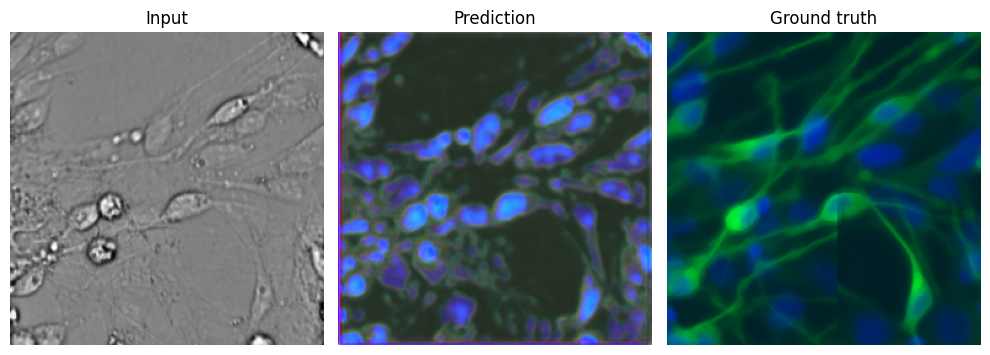



Epoch 2/500
----------
Batch 1/11 : Generator Loss: 1.0948, Discriminator Loss: 0.2564
Batch 6/11 : Generator Loss: 0.9330, Discriminator Loss: 0.2543
Batch 11/11 : Generator Loss: 0.8480, Discriminator Loss: 0.2548
----------
Epoch 2/500 : Gen loss: 0.2397, Disc Loss: 0.2559, Recon Loss: 0.2040, Percep loss: 0.5254
Time taken: 0:00:05.441289


Epoch 3/500
----------
Batch 1/11 : Generator Loss: 0.9295, Discriminator Loss: 0.2557
Batch 6/11 : Generator Loss: 0.8566, Discriminator Loss: 0.2550
Batch 11/11 : Generator Loss: 0.8068, Discriminator Loss: 0.2563
----------
Epoch 3/500 : Gen loss: 0.2523, Disc Loss: 0.2554, Recon Loss: 0.1408, Percep loss: 0.4708
Time taken: 0:00:05.396248


Epoch 4/500
----------
Batch 1/11 : Generator Loss: 0.8556, Discriminator Loss: 0.2553
Batch 6/11 : Generator Loss: 0.8383, Discriminator Loss: 0.2540
Batch 11/11 : Generator Loss: 0.7722, Discriminator Loss: 0.2553
----------
Epoch 4/500 : Gen loss: 0.2538, Disc Loss: 0.2549, Recon Loss: 0.1139, Percep

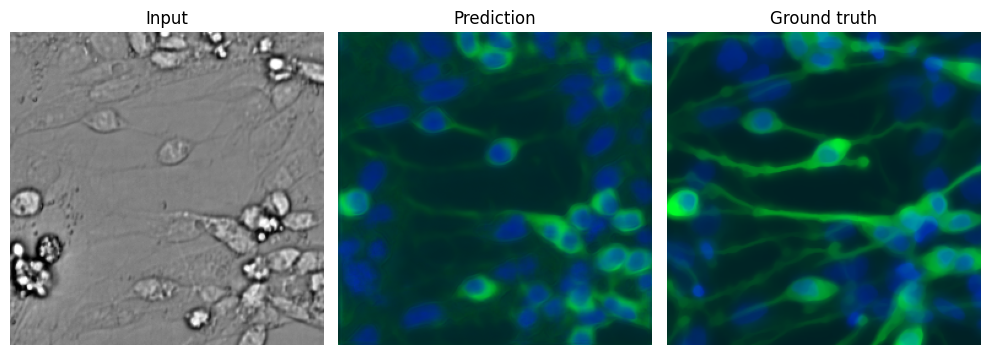



Epoch 52/500
----------
Batch 1/11 : Generator Loss: 0.6845, Discriminator Loss: 0.1766
Batch 6/11 : Generator Loss: 0.8193, Discriminator Loss: 0.1669
Batch 11/11 : Generator Loss: 0.6157, Discriminator Loss: 0.1917
----------
Epoch 52/500 : Gen loss: 0.3413, Disc Loss: 0.1817, Recon Loss: 0.0634, Percep loss: 0.3056
Time taken: 0:00:05.527385


Epoch 53/500
----------
Batch 1/11 : Generator Loss: 0.7474, Discriminator Loss: 0.2299
Batch 6/11 : Generator Loss: 0.6947, Discriminator Loss: 0.1641
Batch 11/11 : Generator Loss: 0.6564, Discriminator Loss: 0.2447
----------
Epoch 53/500 : Gen loss: 0.3475, Disc Loss: 0.1900, Recon Loss: 0.0650, Percep loss: 0.3152
Time taken: 0:00:05.514663


Epoch 54/500
----------
Batch 1/11 : Generator Loss: 0.7729, Discriminator Loss: 0.2162
Batch 6/11 : Generator Loss: 0.6552, Discriminator Loss: 0.1724
Batch 11/11 : Generator Loss: 0.6485, Discriminator Loss: 0.1791
----------
Epoch 54/500 : Gen loss: 0.3223, Disc Loss: 0.1947, Recon Loss: 0.0575, 

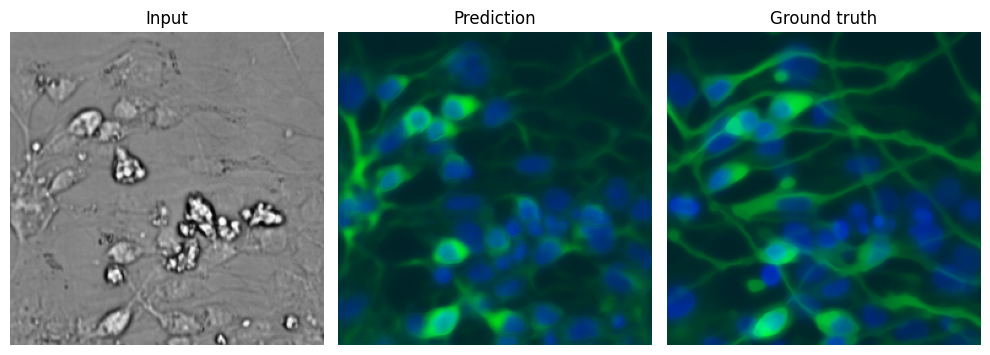



Epoch 102/500
----------
Batch 1/11 : Generator Loss: 0.5793, Discriminator Loss: 0.1973
Batch 6/11 : Generator Loss: 0.7840, Discriminator Loss: 0.1333
Batch 11/11 : Generator Loss: 0.5820, Discriminator Loss: 0.2309
----------
Epoch 102/500 : Gen loss: 0.3222, Disc Loss: 0.1703, Recon Loss: 0.0609, Percep loss: 0.2940
Time taken: 0:00:05.430171


Epoch 103/500
----------
Batch 1/11 : Generator Loss: 0.5735, Discriminator Loss: 0.2704
Batch 6/11 : Generator Loss: 0.7398, Discriminator Loss: 0.1607
Batch 11/11 : Generator Loss: 0.6173, Discriminator Loss: 0.1397
----------
Epoch 103/500 : Gen loss: 0.3246, Disc Loss: 0.2040, Recon Loss: 0.0587, Percep loss: 0.2945
Time taken: 0:00:05.423287


Epoch 104/500
----------
Batch 1/11 : Generator Loss: 0.6538, Discriminator Loss: 0.1407
Batch 6/11 : Generator Loss: 0.7241, Discriminator Loss: 0.2139
Batch 11/11 : Generator Loss: 0.5177, Discriminator Loss: 0.2047
----------
Epoch 104/500 : Gen loss: 0.3643, Disc Loss: 0.2033, Recon Loss: 0.

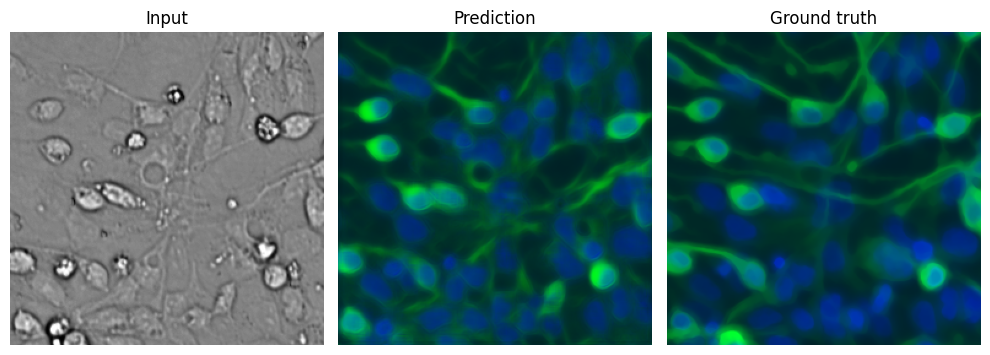



Epoch 152/500
----------
Batch 1/11 : Generator Loss: 0.7161, Discriminator Loss: 0.1287
Batch 6/11 : Generator Loss: 0.7222, Discriminator Loss: 0.1454
Batch 11/11 : Generator Loss: 0.8322, Discriminator Loss: 0.2601
----------
Epoch 152/500 : Gen loss: 0.3301, Disc Loss: 0.1947, Recon Loss: 0.0565, Percep loss: 0.2744
Time taken: 0:00:05.402029


Epoch 153/500
----------
Batch 1/11 : Generator Loss: 0.8117, Discriminator Loss: 0.1535
Batch 6/11 : Generator Loss: 0.6127, Discriminator Loss: 0.3026
Batch 11/11 : Generator Loss: 0.7453, Discriminator Loss: 0.1069
----------
Epoch 153/500 : Gen loss: 0.3242, Disc Loss: 0.1920, Recon Loss: 0.0538, Percep loss: 0.2619
Time taken: 0:00:05.416415


Epoch 154/500
----------
Batch 1/11 : Generator Loss: 0.8090, Discriminator Loss: 0.1808
Batch 6/11 : Generator Loss: 0.7435, Discriminator Loss: 0.1888
Batch 11/11 : Generator Loss: 0.6620, Discriminator Loss: 0.1428
----------
Epoch 154/500 : Gen loss: 0.3587, Disc Loss: 0.1913, Recon Loss: 0.

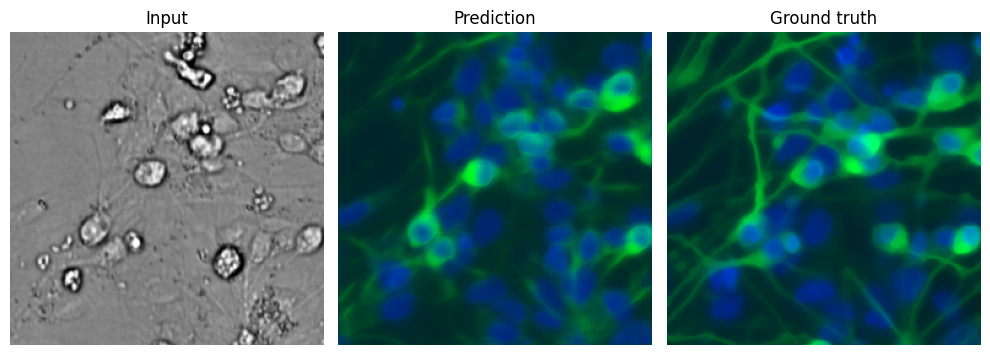



Epoch 202/500
----------
Batch 1/11 : Generator Loss: 0.6155, Discriminator Loss: 0.2363
Batch 6/11 : Generator Loss: 0.5326, Discriminator Loss: 0.1752
Batch 11/11 : Generator Loss: 0.6332, Discriminator Loss: 0.1322
----------
Epoch 202/500 : Gen loss: 0.3959, Disc Loss: 0.2111, Recon Loss: 0.0520, Percep loss: 0.2584
Time taken: 0:00:05.489211


Epoch 203/500
----------
Batch 1/11 : Generator Loss: 0.4918, Discriminator Loss: 0.1237
Batch 6/11 : Generator Loss: 0.7642, Discriminator Loss: 0.1901
Batch 11/11 : Generator Loss: 0.7972, Discriminator Loss: 0.2169
----------
Epoch 203/500 : Gen loss: 0.3293, Disc Loss: 0.1965, Recon Loss: 0.0542, Percep loss: 0.2691
Time taken: 0:00:05.529094


Epoch 204/500
----------
Batch 1/11 : Generator Loss: 0.7060, Discriminator Loss: 0.1085
Batch 6/11 : Generator Loss: 0.7603, Discriminator Loss: 0.1845
Batch 11/11 : Generator Loss: 0.6884, Discriminator Loss: 0.0785
----------
Epoch 204/500 : Gen loss: 0.3486, Disc Loss: 0.1802, Recon Loss: 0.

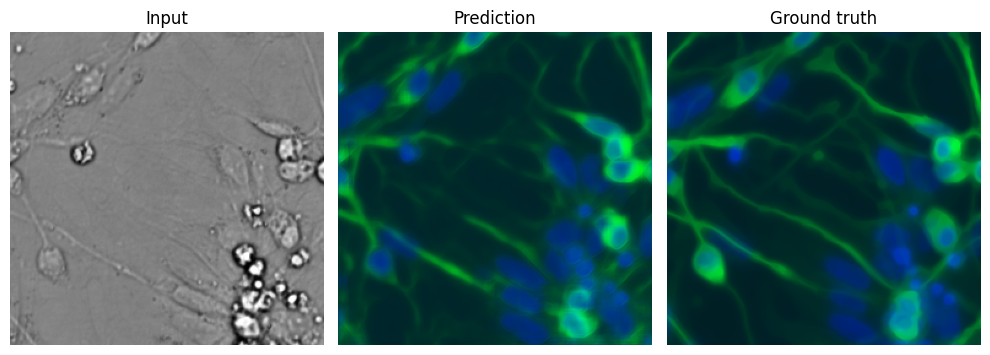



Epoch 252/500
----------
Batch 1/11 : Generator Loss: 0.7228, Discriminator Loss: 0.1727
Batch 6/11 : Generator Loss: 0.6976, Discriminator Loss: 0.2529
Batch 11/11 : Generator Loss: 0.4598, Discriminator Loss: 0.1627
----------
Epoch 252/500 : Gen loss: 0.3860, Disc Loss: 0.1924, Recon Loss: 0.0523, Percep loss: 0.2549
Time taken: 0:00:05.500234


Epoch 253/500
----------
Batch 1/11 : Generator Loss: 0.4447, Discriminator Loss: 0.1849
Batch 6/11 : Generator Loss: 0.8060, Discriminator Loss: 0.2928
Batch 11/11 : Generator Loss: 0.4949, Discriminator Loss: 0.2370
----------
Epoch 253/500 : Gen loss: 0.3708, Disc Loss: 0.2194, Recon Loss: 0.0521, Percep loss: 0.2576
Time taken: 0:00:05.557047


Epoch 254/500
----------
Batch 1/11 : Generator Loss: 0.4197, Discriminator Loss: 0.2002
Batch 6/11 : Generator Loss: 0.7080, Discriminator Loss: 0.1934
Batch 11/11 : Generator Loss: 0.6429, Discriminator Loss: 0.2336
----------
Epoch 254/500 : Gen loss: 0.3533, Disc Loss: 0.2047, Recon Loss: 0.

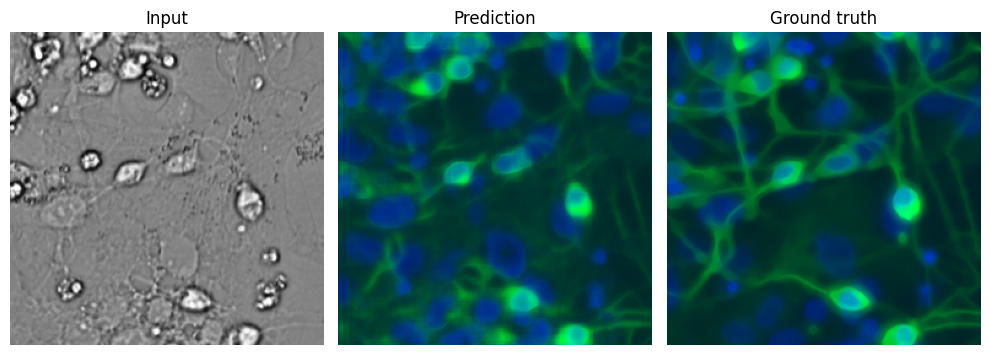



Epoch 302/500
----------
Batch 1/11 : Generator Loss: 0.6480, Discriminator Loss: 0.2111
Batch 6/11 : Generator Loss: 0.5071, Discriminator Loss: 0.2760
Batch 11/11 : Generator Loss: 0.8748, Discriminator Loss: 0.2513
----------
Epoch 302/500 : Gen loss: 0.3888, Disc Loss: 0.2206, Recon Loss: 0.0545, Percep loss: 0.2513
Time taken: 0:00:05.429452


Epoch 303/500
----------
Batch 1/11 : Generator Loss: 0.8766, Discriminator Loss: 0.0988
Batch 6/11 : Generator Loss: 0.4571, Discriminator Loss: 0.3110
Batch 11/11 : Generator Loss: 0.7716, Discriminator Loss: 0.1184
----------
Epoch 303/500 : Gen loss: 0.3727, Disc Loss: 0.1797, Recon Loss: 0.0535, Percep loss: 0.2646
Time taken: 0:00:05.377216


Epoch 304/500
----------
Batch 1/11 : Generator Loss: 0.3935, Discriminator Loss: 0.2112
Batch 6/11 : Generator Loss: 0.6293, Discriminator Loss: 0.1763
Batch 11/11 : Generator Loss: 0.6784, Discriminator Loss: 0.1290
----------
Epoch 304/500 : Gen loss: 0.3175, Disc Loss: 0.1992, Recon Loss: 0.

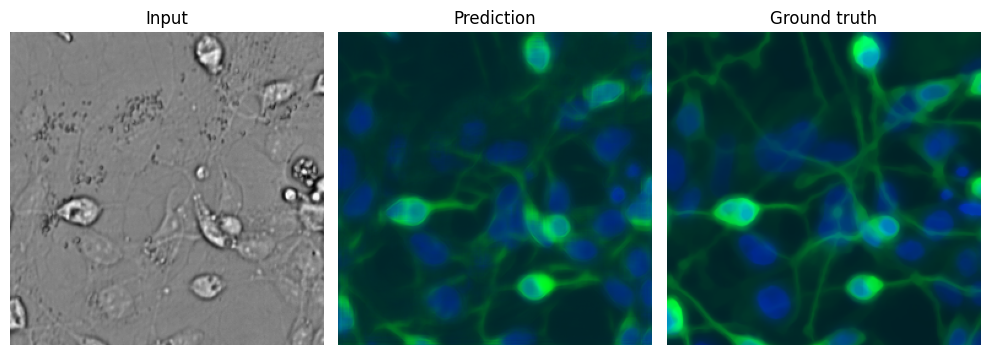



Epoch 352/500
----------
Batch 1/11 : Generator Loss: 0.7918, Discriminator Loss: 0.0495
Batch 6/11 : Generator Loss: 0.8578, Discriminator Loss: 0.2109
Batch 11/11 : Generator Loss: 0.7626, Discriminator Loss: 0.1459
----------
Epoch 352/500 : Gen loss: 0.3687, Disc Loss: 0.1731, Recon Loss: 0.0521, Percep loss: 0.2545
Time taken: 0:00:05.487965


Epoch 353/500
----------
Batch 1/11 : Generator Loss: 0.6572, Discriminator Loss: 0.1733
Batch 6/11 : Generator Loss: 0.6541, Discriminator Loss: 0.1737
Batch 11/11 : Generator Loss: 0.7683, Discriminator Loss: 0.1523
----------
Epoch 353/500 : Gen loss: 0.3240, Disc Loss: 0.2061, Recon Loss: 0.0534, Percep loss: 0.2525
Time taken: 0:00:05.437559


Epoch 354/500
----------
Batch 1/11 : Generator Loss: 0.6573, Discriminator Loss: 0.3224
Batch 6/11 : Generator Loss: 0.6258, Discriminator Loss: 0.1740
Batch 11/11 : Generator Loss: 0.6634, Discriminator Loss: 0.2174
----------
Epoch 354/500 : Gen loss: 0.3481, Disc Loss: 0.2204, Recon Loss: 0.

KeyboardInterrupt: 

In [30]:
# Train the cGAN
EPOCHS = 500
L1_Lambda = 100
LPIPS_Lambda = 10

# Import the packages required for checking the time taken for each epoch
import time
from datetime import timedelta

for epoch in range(EPOCHS+1):
    # Record the start time of each epoch
    start_time = time.time()

    n_batches = len(trainloader)

    print("\n")
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print("-" * 10)

    # Loooping over batches
    G_loss_epochs = []
    D_loss_epochs = []
    Recon_loss_epochs = []
    Percep_loss_epochs = []

    for i, data in enumerate(trainloader, 0):

        # Get the inputs and labels for each batch
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Train the discriminator
        disc_loss = train_discriminator(inputs=inputs, targets=labels, optimizer=discriminator_optimizer)

        # Train the generator
        for _ in range(2):
            adv_loss, rec_loss, percep_loss = train_generator(inputs=inputs, targets=labels, optimizer=generator_optimizer, L1_Lambda=L1_Lambda, LPIPS_Lambda=LPIPS_Lambda)

        gen_loss = adv_loss + rec_loss + percep_loss

        # Print the loss for this batch
        if i % 5 == 0:
            print(
                f"Batch {i+1}/{n_batches} : Generator Loss: {gen_loss.item():.4f}, Discriminator Loss: {disc_loss.item():.4f}"
            )

        # Save the loss for this batch
        G_loss_epochs.append(adv_loss.item())
        D_loss_epochs.append(disc_loss.item())
        Recon_loss_epochs.append(rec_loss.item())
        Percep_loss_epochs.append(percep_loss.item())

    # Record the end time of each epoch
    end_time = time.time()

    # Print the loss for this epoch
    print("-" * 10)
    print(
        f"Epoch {epoch+1}/{EPOCHS} : Gen loss: {np.mean(G_loss_epochs):.4f}, Disc Loss: {np.mean(D_loss_epochs):.4f}, Recon Loss: {np.mean(Recon_loss_epochs):.4f}, Percep loss: {np.mean(Percep_loss_epochs):.4f}"
    )
    print(f"Time taken: {timedelta(seconds=end_time-start_time)}")


    # Evaluate model every epoch
    if epoch % 50 == 0:
        for i, data, in enumerate(testloader, 0):
            # Get the inputs and labels for each batch
            test_inputs, test_labels = data
            test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

            break

        # Evaluate the model
        fig = evaluate_model(test_inputs, test_labels)
        plt.show()

    # Save the loss for this epoch
    Generator_losses.append(np.mean(G_loss_epochs))
    Discriminator_losses.append(np.mean(D_loss_epochs))
    Reconstruction_losses.append(np.mean(Recon_loss_epochs))
    Perceptual_losses.append(np.mean(Percep_loss_epochs))

Let us now visualize different losses.

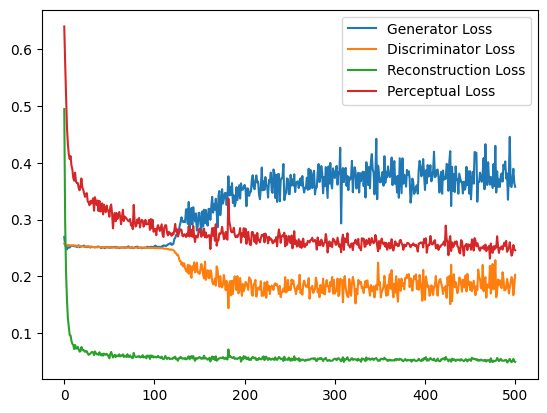

In [ ]:
plt.figure()
plt.plot(Generator_losses, label="Generator Loss")
plt.plot(Discriminator_losses, label="Discriminator Loss")
plt.plot(Reconstruction_losses, label="Reconstruction Loss")
plt.plot(Perceptual_losses, label="Perceptual Loss")
plt.legend()

Let us now evaluate the model. We will also measure the `SSIM` score (Structural Similarity Index) between the generated fluorescent image and the label. The SSIM score is a perceptual metric that is used to measure the similarity between two images. The SSIM score ranges from `-1` to `1` with `1` being the highest similarity. We will use the `torchmetrics` library to compute the SSIM score.

In [ ]:
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM

transform_eval = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomCrop((512))
])

eval_dataset = VirtualStainingDataset(root, train=False, transform=transform_eval, normalize=normalize, preload=True)

img, target = eval_dataset[np.random.randint(0, len(test_dataset))]

generator.eval()

fig = evaluate_model(img.unsqueeze(0).to(device), target.unsqueeze(0).to(device))
plt.show()

# Calculate the SSIM score
ssim = SSIM().to(device)
ssim_score = ssim(generator(img.unsqueeze(0).to(device)), target.unsqueeze(0).to(device))
print(ssim_score)